In [2]:
import os
from lxml import etree
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import *

In [3]:
class Config:
    """
    参考https://github.com/pjreddie/darknet/blob/master/cfg/yolov2-voc.cfg
    """
    def __init__(self):
        # Training
        self.IMAGE_W = 416
        self.IMAGE_H = 416
        self.GRID_W = 13
        self.GRID_H = 13
        self.ANCHORS_NUM = 5
        self.CLASSES_NUM = 20
        self.NOOBJECT_LAMBDA = 1
        self.OBJECT_LAMBDA = 5
        self.CLASS_LAMBDA = 1
        self.COORD_LAMBDA = 1
        # 论文中提到的K-means算法得到的VOC数据集的5个box的信息
        self.ANCHORS = [1.3221, 1.73145, 3.19275, 4.00944, 5.05587, 8.09892, 9.47112, 4.84053, 11.2364, 10.0071]
        self.ANCHORS = np.array(self.ANCHORS)
        self.ANCHORS = self.ANCHORS.reshape(-1, 2)

        self.VOC_NAME_LABEL_CLASS = {
            'none': (0, 'Background'),
            'aeroplane': (1, 'Vehicle'),
            'bicycle': (2, 'Vehicle'),
            'bird': (3, 'Animal'),
            'boat': (4, 'Vehicle'),
            'bottle': (5, 'Indoor'),
            'bus': (6, 'Vehicle'),
            'car': (7, 'Vehicle'),
            'cat': (8, 'Animal'),
            'chair': (9, 'Indoor'),
            'cow': (10, 'Animal'),
            'diningtable': (11, 'Indoor'),
            'dog': (12, 'Animal'),
            'horse': (13, 'Animal'),
            'motorbike': (14, 'Vehicle'),
            'person': (15, 'Person'),
            'pottedplant': (16, 'Indoor'),
            'sheep': (17, 'Animal'),
            'sofa': (18, 'Indoor'),
            'train': (19, 'Vehicle'),
            'tvmonitor': (20, 'Indoor'),
        }
        self.VOC_NAME_LABEL = {key:v[0] for key,v in self.VOC_NAME_LABEL_CLASS.items()}
        self.VOC_LABEL_NAME = {v[0]:key for key,v in self.VOC_NAME_LABEL_CLASS.items()}

In [4]:
def read_example_list(path):
    """
    读取训练集或验证集
    :param path: 路径
    :return: list
    """
    with tf.io.gfile.GFile(path) as f:
        lines = f.readlines()
    return [line.strip().split(' ')[0] for line in lines]

def parse_xml_to_dict(xml):
    """
    递归地将 xml 转化为 字典
    :param xml: 通过解析 xml 得到的 lxml.etree 格式
    :return: 包含 xml 的字典
    """
    if len(xml) == 0:
        return {xml.tag: xml.text}
    result = {}
    for child in xml:
        child_result = parse_xml_to_dict(child)
        if child.tag != 'object':
            result[child.tag] = child_result[child.tag]
        else:
            if child.tag not in result:
                result[child.tag] = []
            result[child.tag].append(child_result[child.tag])
    return {xml.tag: result}

def transform(x, y, config):
    """
    从数据集中生成一个 batch size 的标签值， 准备在计算损失时和预测值比较
    :param x: 一个 batch size 的图片 (batch size, h, w, 3)
    :param y: 一个batch size 的 label (batch size, xmin, ymin, xmax, ymax, label)
    :param config: 配置
    :return: batch
        - x : 要预测的图片（batch_size, IMAGE_H, IMAGE_W, 3）
        - detector_mask : 是否有 bounding box 在格子内预测（batch, size, GRID_W, GRID_H, anchors_num, 1）
        - y_true_anchor_boxes : bounding box 坐标（batch_size, GRID_W, GRID_H, anchors_num, 5）
        - y_true_class_hot : 预测类别的 one hot 编码（batch_size, GRID_W, GRID_H, anchors_num, class_num)
        - y_true_boxes_all : 标签值（batch_size, max annotation(这里设置为100), 5）
    """
    anchors = config.ANCHORS
    anchors_num = anchors.shape[0]
    y = y.numpy()
    batch_size = y.shape[0]
    detector_mask = np.zeros([batch_size, config.GRID_W, config.GRID_H, anchors_num, 1])
    y_true_anchor_boxes = np.zeros([batch_size, config.GRID_W, config.GRID_H, anchors_num, 5])
    y_true_class_hot = np.zeros([batch_size, config.GRID_W, config.GRID_H, anchors_num, config.CLASSES_NUM])
    y_true_boxes_all = np.zeros(y.shape)

    for i in range(batch_size):
        boxes = y[i]
        for j, box in enumerate(boxes):
            w = box[2] - box[0]
            h = box[3] - box[1]
            cx = (box[0] + box[2])/2  # 中心点坐标
            cy = (box[1] + box[3])/2

            w *= config.GRID_W
            h *= config.GRID_H
            cx *= config.GRID_W
            cy *= config.GRID_H

            y_true_boxes_all[i, j] = np.array([cx, cy, w, h, box[4]])
            if w * h <= 0:
                continue
            # 网格 index
            cell_col = np.floor(cx).astype(np.int)
            cell_row = np.floor(cy).astype(np.int)
            # 寻找 IoU 最高的 anchor
            anchors_w, anchors_h = anchors[:, 0], anchors[:, 1]
            intersect = np.minimum(w, anchors_w) * np.minimum(h, anchors_h)
            union = anchors_w * anchors_h + w * h - intersect
            iou = intersect / union
            anchor_best = np.argmax(iou)

            class_index = int(box[4])
            y_true_anchor_boxes[i, cell_col, cell_row, anchor_best] = [cx, cy, w, h, class_index]
            y_true_class_hot[i, cell_col, cell_row, anchor_best, class_index-1] = 1
            detector_mask[i, cell_col, cell_row, anchor_best] = 1

    detector_mask = tf.convert_to_tensor(detector_mask, dtype='int64')
    y_true_anchor_boxes = tf.convert_to_tensor(y_true_anchor_boxes, dtype='float32')
    y_true_boxes_all = tf.convert_to_tensor(y_true_boxes_all, dtype='float32')
    y_true_class_hot = tf.convert_to_tensor(y_true_class_hot, dtype='float32')
    batch = (x, detector_mask, y_true_anchor_boxes, y_true_class_hot, y_true_boxes_all)
    return batch

In [5]:
# 法二：即时的从硬盘读取，不用生成tfrecords，不需事先把每张图片的标签读进来
def get_imgPath_and_annotations(data_path, years, config,
                                image_subdirectory = 'JPEGImages',
                                annotations_dir = 'Annotations',
                                ignore_difficult_instances = False):
    """
    得到图片的路径和box
    :param data_path: 根目录
    :param years: 数据集年份 2007/2012
    :param config: 配置
    :param image_subdirectory: 图片子文件夹
    :param annotations_dir: 标签子文件夹
    :param ignore_difficult_instances: 忽略复杂数据
    :return: 路径 box
    """
    annotations_list = []
    for year in years.keys():
        sets = years[year]
        for _set in sets:
            examples_path = os.path.join(data_path, year, 'ImageSets', 'Main', _set + '.txt')
            annotations_path = os.path.join(data_path, year, annotations_dir)
            examples_list = read_example_list(examples_path)
            annotation_list = [os.path.join(annotations_path, example + '.xml') for example in examples_list]
            annotations_list += annotation_list

    img_names = []
    max_obj = 200
    annotations = []  # 存放每个图片的box
    for path in annotations_list:
        with tf.io.gfile.GFile(path, 'r') as f:
            xml_str = f.read()
        xml = etree.fromstring(xml_str)
        data = parse_xml_to_dict(xml)['annotation']
        width = int(data['size']['width'])
        height = int(data['size']['height'])

        boxes = []
        if 'object' not in data:
            continue
        for obj in data['object']:
            difficult = bool(int(obj['difficult']))
            if ignore_difficult_instances and difficult:
                continue
            box = np.array([
                float(obj['bndbox']['xmin']) / width,
                float(obj['bndbox']['ymin']) / height,
                float(obj['bndbox']['xmax']) / width,
                float(obj['bndbox']['ymax']) / height,
                config.VOC_NAME_LABEL[obj['name']]
            ])
            boxes.append(box)  # 一个图片的box可能有多个
        boxes = np.stack(boxes)
        annotations.append(boxes)

        img_path = os.path.join(data['folder'], image_subdirectory, data['filename'])
        img_path = os.path.join(data_path, img_path)
        img_names.append(img_path)
    true_boxes = np.zeros([len(img_names), max_obj, 5])
    for idx, boxes in enumerate(annotations):
        true_boxes[idx, :boxes.shape[0]] = boxes
    return img_names, true_boxes

def parse_image(filename, true_boxes, img_h, img_w):
    """
    得到图片和 box
    :param filename: 图片路径
    :param true_boxes: box
    :param img_h: 期望图片长
    :param img_w: 期望图片宽
    :return: 图片 box
    """
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (img_h, img_w))
    return image, true_boxes

def OB_tensor_slices_dataset(data_path, years, batch_size, config, shuffle=False):
    img_names, boxes = get_imgPath_and_annotations(data_path, years, config)
    dataset = tf.data.Dataset.from_tensor_slices((img_names, boxes))
    dataset = dataset.map(lambda x, y:parse_image(x, y, img_h=config.IMAGE_H, img_w=config.IMAGE_W))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=500)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)  # 提前获取数据存在缓存里来减少gpu因为缺少数据而等待的情况
    return dataset

In [6]:
def space_to_depth(x):
    return tf.nn.space_to_depth(x, block_size=2)

def yolo(config):
    """
    训练模型，即去掉最后一个卷积层，转而增加了三个3*3*1024的卷积层,集体参看yolov2-voc.cfg文件
    :param config: 配置文件
    :return: 网络模型
    """
    input_image = tf.keras.layers.Input((config.IMAGE_H, config.IMAGE_W, 3), dtype='float32')
    # 1
    x = Conv2D(32, (3, 3), strides=(1, 1), padding='same', name='conv_1', use_bias=False)(input_image)
    x = BatchNormalization(name='norm_1')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    # 2
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', name='conv_2', use_bias=False)(x)
    x = BatchNormalization(name='norm_2')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    # 3
    x = Conv2D(128, (3, 3), strides=(1, 1), padding='same', name='conv_3', use_bias=False)(x)
    x = BatchNormalization(name='norm_3')(x)
    x = LeakyReLU(alpha=0.1)(x)
    # 4
    x = Conv2D(64, (1, 1), strides=(1, 1), padding='same', name='conv_4', use_bias=False)(x)
    x = BatchNormalization(name='norm_4')(x)
    x = LeakyReLU(alpha=0.1)(x)
    # 5
    x = Conv2D(128, (3, 3), strides=(1, 1), padding='same', name='conv_5', use_bias=False)(x)
    x = BatchNormalization(name='norm_5')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    # 6
    x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
    x = BatchNormalization(name='norm_6')(x)
    x = LeakyReLU(alpha=0.1)(x)
    # 7
    x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
    x = BatchNormalization(name='norm_7')(x)
    x = LeakyReLU(alpha=0.1)(x)
    # 8
    x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
    x = BatchNormalization(name='norm_8')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    # 9
    x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
    x = BatchNormalization(name='norm_9')(x)
    x = LeakyReLU(alpha=0.1)(x)
    # 10
    x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
    x = BatchNormalization(name='norm_10')(x)
    x = LeakyReLU(alpha=0.1)(x)
    # 11
    x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
    x = BatchNormalization(name='norm_11')(x)
    x = LeakyReLU(alpha=0.1)(x)
    # 12
    x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
    x = BatchNormalization(name='norm_12')(x)
    x = LeakyReLU(alpha=0.1)(x)
    # 13
    x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
    x = BatchNormalization(name='norm_13')(x)
    x = LeakyReLU(alpha=0.1)(x)
    skip_connection = x
    x = MaxPooling2D(pool_size=(2, 2))(x)
    # 14
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
    x = BatchNormalization(name='norm_14')(x)
    x = LeakyReLU(alpha=0.1)(x)
    # 15
    x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
    x = BatchNormalization(name='norm_15')(x)
    x = LeakyReLU(alpha=0.1)(x)
    # 16
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
    x = BatchNormalization(name='norm_16')(x)
    x = LeakyReLU(alpha=0.1)(x)
    # 17
    x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
    x = BatchNormalization(name='norm_17')(x)
    x = LeakyReLU(alpha=0.1)(x)
    # 18
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
    x = BatchNormalization(name='norm_18')(x)
    x = LeakyReLU(alpha=0.1)(x)
    # 19 把最后一层卷积层移除,添加3个1024*3*3卷积层
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
    x = BatchNormalization(name='norm_19')(x)
    x = LeakyReLU(alpha=0.1)(x)
    # 20
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
    x = BatchNormalization(name='norm_20')(x)
    x = LeakyReLU(alpha=0.1)(x)
    # 21 passthrough层
    skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
    skip_connection = BatchNormalization(name='norm_21')(skip_connection)
    skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
    skip_connection = Lambda(space_to_depth)(skip_connection)
    x = concatenate([skip_connection, x])
    # 22
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
    x = BatchNormalization(name='norm_22')(x)
    x = LeakyReLU(alpha=0.1)(x)
    # 23 1*1的卷积层生成预测输出
    x = Conv2D(config.ANCHORS_NUM * (4 + 1 + config.CLASSES_NUM), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
    output = Reshape((config.GRID_W, config.GRID_H, config.ANCHORS_NUM, 4 + 1 + config.CLASSES_NUM))(x)

    yolo_model = tf.keras.models.Model(inputs=input_image, outputs=output)
    return yolo_model

In [8]:
weight_path = 'weight/training_1_epoch28_966.21136.h5'
cfg = Config()
model = yolo(cfg)
data_dir = 'VOCdevkit'
val_set = {'VOC2012':['val']}
batch_size = 6
dataset_val = OB_tensor_slices_dataset(data_dir, val_set, batch_size, cfg, shuffle=False)
model.load_weights(weight_path)

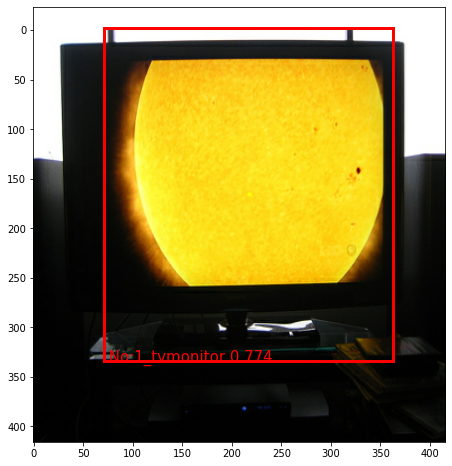

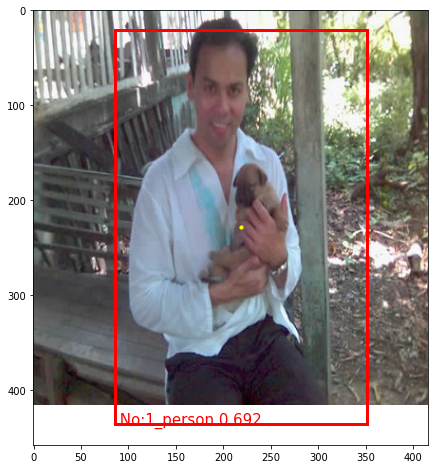

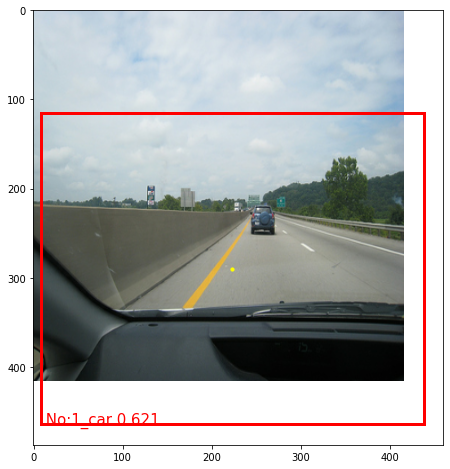

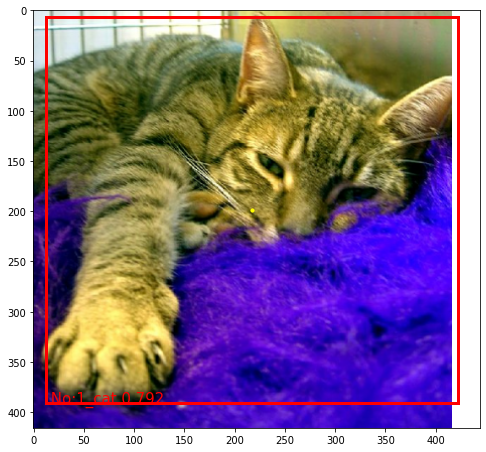

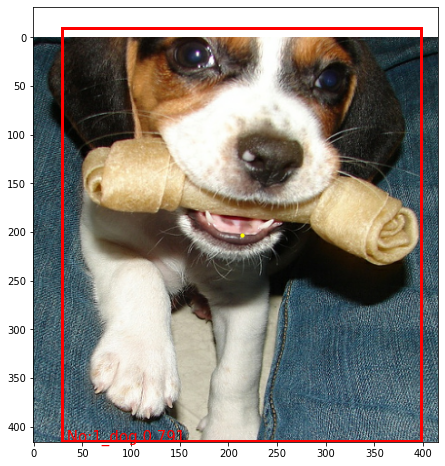

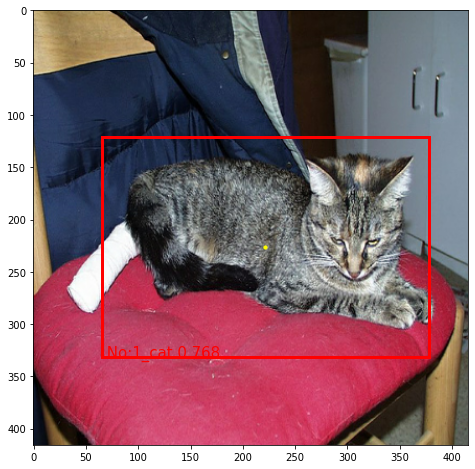

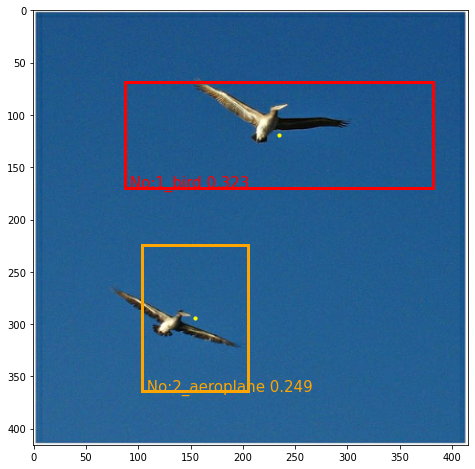

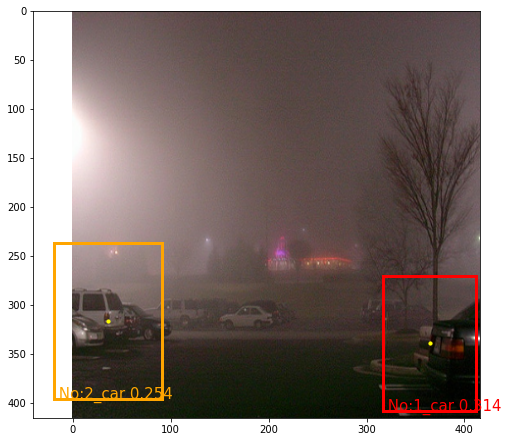

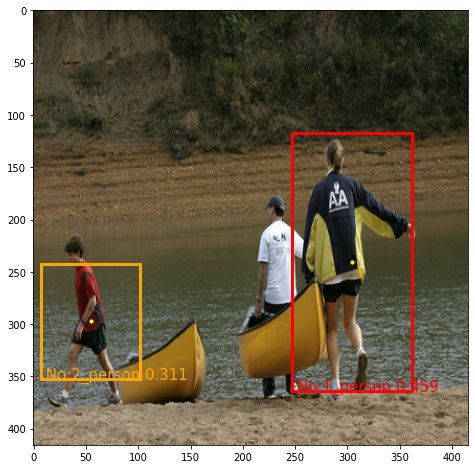

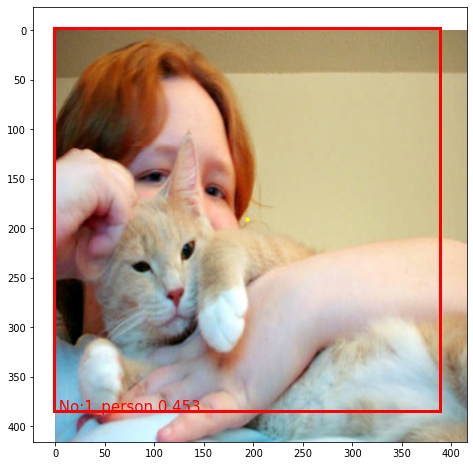

In [27]:
def plot_img(img, boxes, labels, scores, config):
    """
    画图
    :param img: 图片
    :param boxes: 物体位置box
    :param labels: 标签
    :param scores: 得分
    :param config: 配置
    :return:
    """
    # 画图
    fig, ax = plt.subplots(1, figsize=(8, 8))
    img = img.numpy()
    boxes = boxes.numpy().reshape(-1, 4)
    labels = labels.numpy()
    scores = scores.numpy()

    ax.imshow(img)
    img_h, img_w = img.shape[0: 2]
    colors = ['r', 'orange', 'g', 'b', 'pink', 'purple']
    count = 0
    for box, label, score in zip(boxes, labels, scores):
        cx, cy, w, h = box
        if w * h <= 0:
            continue
        count += 1
        cx = cx / config.GRID_W * img_w
        cy = cy/config.GRID_H * img_h
        w = w/config.GRID_W * img_w
        h = h/config.GRID_H * img_h
        name = cfg.VOC_LABEL_NAME[label+1]
        ax.scatter(cx, cy, s=10, c='yellow')
        text = ' No:%d' % count + '_'+ name + ' %.3f' % score
        ax.text(cx-w/2, cy+h/2, text, fontdict={'size':15, 'color':colors[count-1]})
        rect = patches.Rectangle((cx-w/2,cy-h/2), w, h, edgecolor=colors[count-1], linewidth=3.0, facecolor='none')
        ax.add_patch(rect)

def display_img(input_img, model, score_threshold, iou_threshold, config):
    """
    把标签展示到图片上
    :param input_img: 测试图片
    :param model: yolo模型
    :param score_threshold: 根据box_conf * box_class_prob筛选boxes
    :param iou_threshold: 对boxes做NMS时的阈值
    :param config: 配置
    :return: box位置
    """
    y_pred = model.predict_on_batch(tf.expand_dims(input_img, 0))
    cell_coord_x = tf.cast(tf.reshape(tf.tile(tf.range(config.GRID_W), [config.GRID_H]), (1, config.GRID_H, config.GRID_W, 1, 1)), tf.float32)
    cell_coord_y = tf.transpose(cell_coord_x, (0,2,1,3,4))
    cell_coords = tf.tile(tf.concat([cell_coord_x, cell_coord_y], -1), [y_pred.shape[0], 1, 1, 5, 1])
    anchors = config.ANCHORS

    pred_xy = K.sigmoid(y_pred[:,:,:,:,0:2])
    pred_xy = pred_xy + cell_coords
    pred_wh = K.exp(y_pred[:,:,:,:,2:4]) * anchors

    box_conf = K.sigmoid(y_pred[:,:,:,:,4:5])
    box_class_prob = K.softmax(y_pred[:,:,:,:,5:])
    box_xy1 = pred_xy - 0.5 * pred_wh
    box_xy2 = pred_xy + 0.5 * pred_wh
    boxes = K.concatenate((box_xy1, box_xy2), axis=-1)

    box_scores = box_conf * box_class_prob

    box_classes = K.argmax(box_scores, axis=-1) # 最好的分数的 index
    box_class_scores = K.max(box_scores, axis=-1) # 最好的分数
    prediction_mask = box_class_scores >= score_threshold
    boxes = tf.boolean_mask(boxes, prediction_mask)
    scores = tf.boolean_mask(box_class_scores, prediction_mask)
    classes = tf.boolean_mask(box_classes, prediction_mask)

    # NMS（非极大值抑制）
    selected_idx = tf.image.non_max_suppression(boxes, scores, 50, iou_threshold=iou_threshold)
    boxes = K.gather(boxes, selected_idx)  # [n, 4]
    scores = K.gather(scores, selected_idx)  # [n,]
    classes = K.gather(classes, selected_idx)  # [n,]
    _boxes = K.stack((0.5*(boxes[:,0] + boxes[:,2]),
                      0.5*(boxes[:,1] + boxes[:,3]),
                      boxes[:,2] - boxes[:,0],
                      boxes[:,3] - boxes[:,1]),
                      axis=-1) # x1, y1, x2, y2 ==> cx, cy, w, h

    plot_img(input_img, _boxes, classes, scores, config)
    return _boxes

for bs_idx, (x,y) in enumerate(dataset_val):
    x, detector_mask, y_true_anchor_boxes, y_true_class_hot, y_true_boxes_all = transform(x, y, cfg)

    # 阈值的设定不能泛化，而且还识别错一个
    score_threshold = 0.21
    iou_threshold = 0.05

    display_img(x[0], model, score_threshold, iou_threshold, cfg)
    if (bs_idx + 1) == 10:
        break
    plt.show()